Importing the dependencies


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings



In [58]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/BrainTumor'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# tumor_dataset = imgd.flow_from_directory('/content/drive/MyDrive/Dataset/BrainTumor/Training')


/content/drive/MyDrive/Dataset/BrainTumor/.DS_Store
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(42).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(61).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(100).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(53).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(57).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(60).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(68).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(39).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(65).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(103).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(91).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(26).jpg
/content/drive/MyDrive/Dataset/BrainTumor/Testing/no_tumor/image(72).j

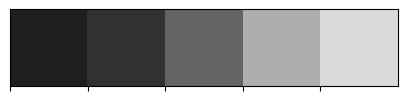

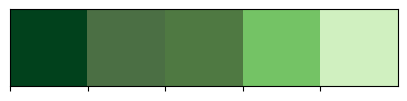

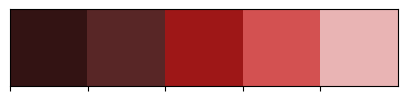

In [59]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

Data Preprocessing

In [60]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the directories into a Python list and then converting them into numpy arrays after resizing it.

In [61]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dataset/BrainTumor','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dataset/BrainTumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 78.91it/s]


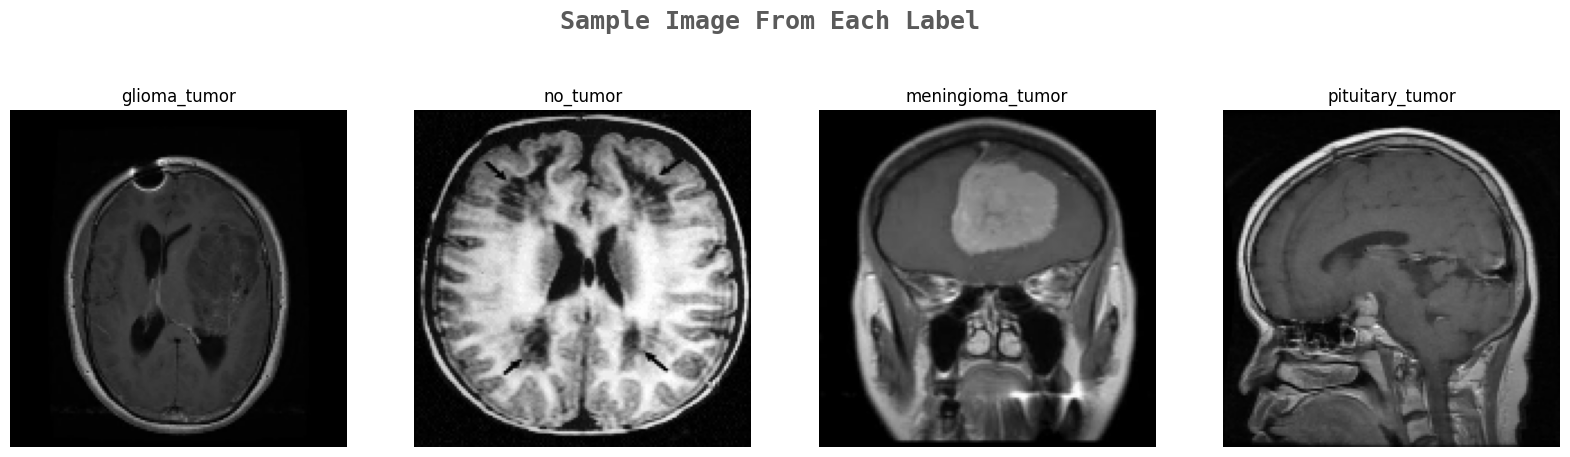

In [62]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [63]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [64]:
X_train.shape

(3274, 150, 150, 3)

Dividing the dataset into Training and Testing sets.

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing One Hot Encoding on the labels after converting it into numerical values:

In [66]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the EfficientNetB0 model which will use the weights from the ImageNet dataset.

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [67]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

GlobalAveragePooling2D -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

Dropout -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

Dense -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [68]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)


In [69]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 150, 150, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 150, 150, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

Finally Compile the model

In [70]:
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

Callbacks -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using TensorBoard, ModelCheckpoint and ReduceLROnPlateau callback functions

In [71]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [85]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =15)

Epoch 1/15
74/74 [==============================] - 11s 142ms/step - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.0495 - val_accuracy: 0.9864
Epoch 2/15
74/74 [==============================] - 10s 136ms/step - loss: 0.0126 - accuracy: 0.9975 - val_loss: 0.1109 - val_accuracy: 0.9763
Epoch 3/15
74/74 [==============================] - 10s 138ms/step - loss: 0.0082 - accuracy: 0.9979 - val_loss: 0.1334 - val_accuracy: 0.9678
Epoch 4/15
74/74 [==============================] - 10s 138ms/step - loss: 0.0207 - accuracy: 0.9941 - val_loss: 0.0720 - val_accuracy: 0.9746
Epoch 5/15
74/74 [==============================] - 10s 138ms/step - loss: 0.0216 - accuracy: 0.9941 - val_loss: 0.3472 - val_accuracy: 0.9034
Epoch 6/15
74/74 [==============================] - 10s 134ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.2329 - val_accuracy: 0.9492
Epoch 7/15
74/74 [==============================] - 10s 139ms/step - loss: 0.0529 - accuracy: 0.9847 - val_loss: 0.4376 - val_accuracy: 0.8932

In [73]:
# filterwarnings('ignore')

# epochs = [i for i in range(12)]
# fig, ax = plt.subplots(1,2,figsize=(14,7))
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']

# fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
#              fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

# sns.despine()
# ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
#            label = 'Training Accuracy')
# ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
#            label = 'Validation Accuracy')
# ax[0].legend(frameon=False)
# ax[0].set_xlabel('Epochs')
# ax[0].set_ylabel('Accuracy')

# sns.despine()
# ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
#            label ='Training Loss')
# ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
#            label = 'Validation Loss')
# ax[1].legend(frameon=False)
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Training & Validation Loss')

# fig.show()

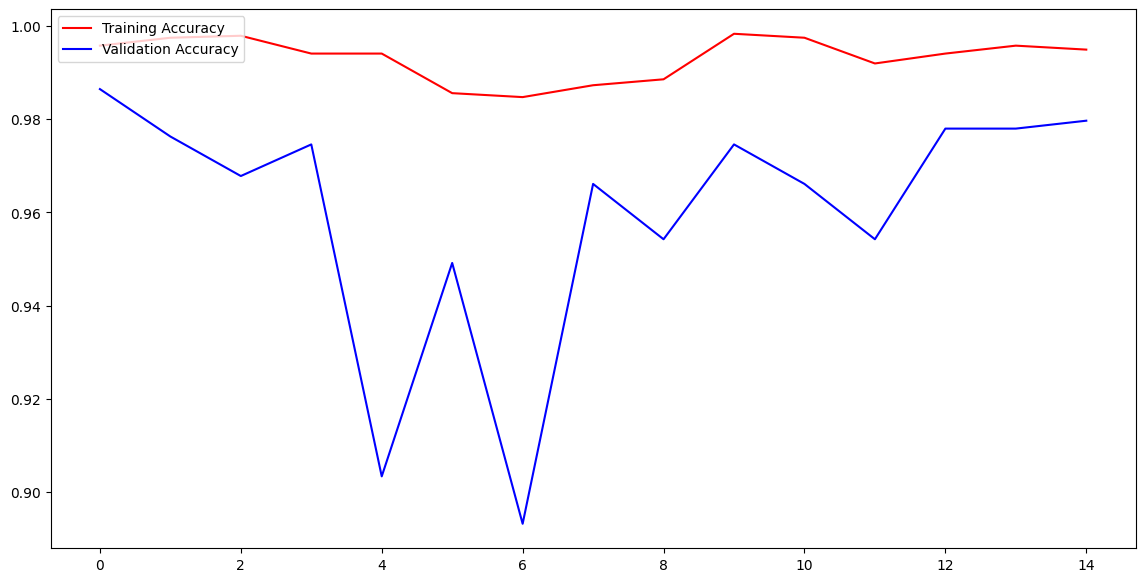

[0.9957554936408997, 0.9974533319473267, 0.9978777766227722, 0.9940577149391174, 0.9940577149391174, 0.9855687618255615, 0.9847198724746704, 0.9872665405273438, 0.9885398745536804, 0.9983022212982178, 0.9974533319473267, 0.9919354915618896, 0.9940577149391174, 0.9957554936408997, 0.9949066042900085]
[0.9864406585693359, 0.9762712121009827, 0.9677966237068176, 0.9745762944221497, 0.9033898115158081, 0.9491525292396545, 0.8932203650474548, 0.9661017060279846, 0.9542372822761536, 0.9745762944221497, 0.9661017060279846, 0.9542372822761536, 0.9779661297798157, 0.9779661297798157, 0.9796609878540039]


In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

print(acc)
print(val_acc)

In [87]:
print(acc)
print(val_acc)


[0.9957554936408997, 0.9974533319473267, 0.9978777766227722, 0.9940577149391174, 0.9940577149391174, 0.9855687618255615, 0.9847198724746704, 0.9872665405273438, 0.9885398745536804, 0.9983022212982178, 0.9974533319473267, 0.9919354915618896, 0.9940577149391174, 0.9957554936408997, 0.9949066042900085]
[0.9864406585693359, 0.9762712121009827, 0.9677966237068176, 0.9745762944221497, 0.9033898115158081, 0.9491525292396545, 0.8932203650474548, 0.9661017060279846, 0.9542372822761536, 0.9745762944221497, 0.9661017060279846, 0.9542372822761536, 0.9779661297798157, 0.9779661297798157, 0.9796609878540039]


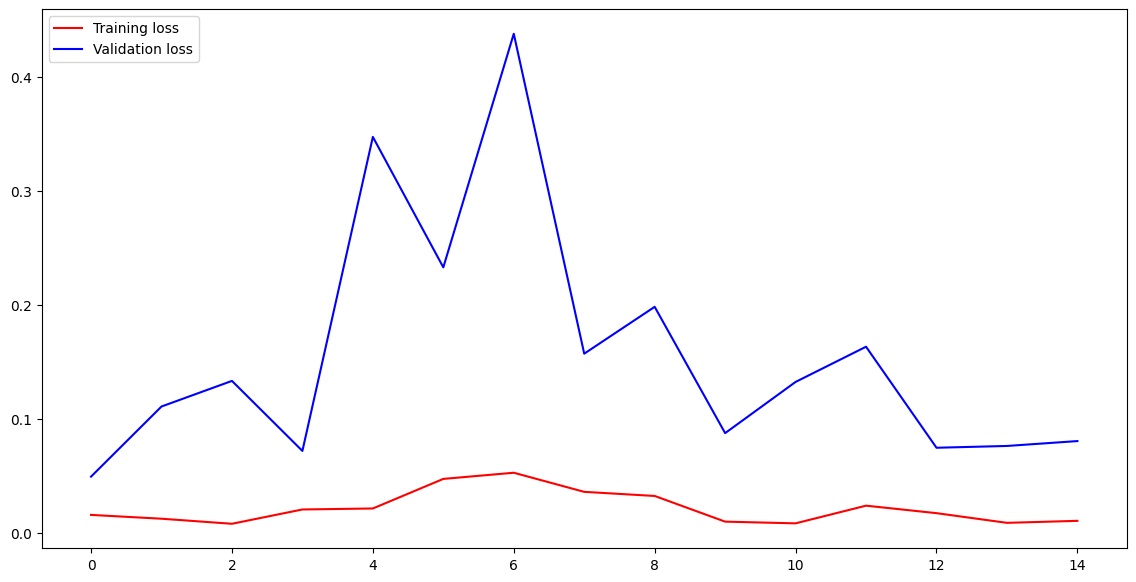

In [88]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

Prediction


I've used the argmax function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.

In [89]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 0s 33ms/step


Evaluation
In this,
0 - Glioma Tumor
1 - No Tumor
2 - Meningioma Tumor
3 - Pituitary Tumor

In [90]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        97
           1       0.96      0.96      0.96        48
           2       0.95      0.98      0.96        94
           3       0.99      0.98      0.98        89

    accuracy                           0.97       328
   macro avg       0.97      0.97      0.97       328
weighted avg       0.97      0.97      0.97       328



In [91]:
import sklearn.metrics
acc = sklearn.metrics.accuracy_score(y_test_new,pred)
print(acc *100)



96.95121951219512


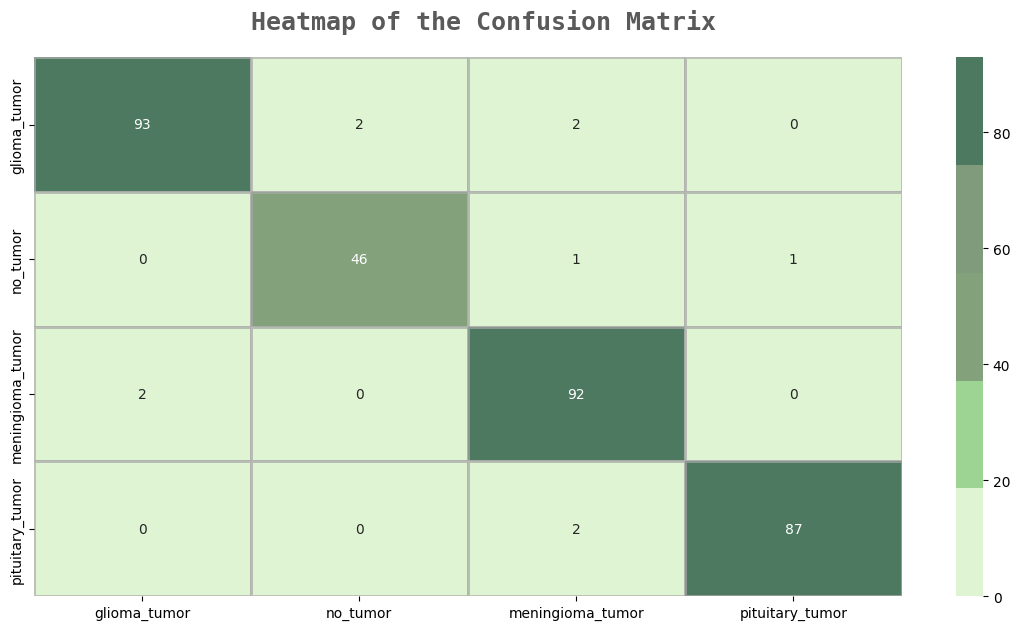

In [92]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

Conclusion

Image Classification with the help of CNN using Transfer Learning which gave an accuracy of around 98%.

Saving the Model


In [93]:
model.save('BrainTumor.h5')
new_model = tf.keras.models.load_model('brainTumor.h5')

# Show the model architecture
new_model.summary()

TypeError: ignored